# Multilayer Perceptron to Predict one Feature of the WDN
The Neural Network is fed with:
- Pressure
- Flow
- Base Demand
- Demand Value

The aim is to predict one of them using the others, without topological information.

Our **input** is the 'state' of the Network at a given time, identified by the following features:
- Pressure
- Flow
- Base Demand

for each node. 
The **output** is the Demand Value of every node at that time.
Having $n$ nodes and $f=3$ features, the input is a matrix $X^{n, 3}$ and the output is the vector $Y^{n}$. 
We can squeeze the input to have a feature vector $\bar{X}^{n\times 3}$.

In [123]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

from keras.models import Sequential
from keras.layers import Dense, Input

In [208]:
DROP = [
    'link_type', 'velocity', 'status', 'start_node', 'end_node',
    'node_type', 'x_pos', 'y_pos', 'head_value',
    'leak_area_value', 'leak_discharge_value', 'leak_demand_value', 'has_leak',
]
TARGET = 'demand_value'

In [209]:
def extract_data(path):
    dataset = pd.read_csv(path, sep=';')
    dataset = dataset.drop(columns=set(dataset.columns).intersection(DROP))
    dataset['hour'] = dataset['hour'].apply(lambda x: int(x.split(':')[0]))
    dataset = dataset.rename(columns={'nodeID': 'ID', 'linkID': 'ID'})
    dataset = dataset.set_index(['hour', 'ID']).unstack(level=1)
    return dataset


def load_data(edges=False):
    # Load the data
    data_edges = extract_data('dati/networks/dataset-network-out/NET_0_bd_0_005_h_720_leak_area_0_links.csv')
    data_nodes = extract_data('dati/networks/dataset-network-out/NET_0_bd_0_005_h_720_leak_area_0_nodes.csv')
    data = pd.concat([data_edges, data_nodes], axis=1)
    if not edges:
        # Remove data from the pipes
        data = data.drop(columns=['flowrate'], level=0)
    return data

def scale_data(data):
    # Scale the data
    scaler = MinMaxScaler()
    data = scaler.fit_transform(data)
    return data, scaler

base_demand                                                              \
ID        880000    880001    880002    880003    880004    880005    880006   
hour                                                                           
0       0.004848  0.004199  0.002250  0.004689  0.003701  0.002040  0.001341   
1       0.001145  0.001529  0.000318  0.000005  0.004973  0.004885  0.000945   
2       0.004169  0.003663  0.003149  0.002765  0.000915  0.003125  0.002784   
3       0.001266  0.004262  0.000741  0.001314  0.004219  0.004595  0.004942   
4       0.001318  0.001740  0.000669  0.004558  0.002984  0.003776  0.001387   

                                    ... pressure_value                      \
ID      880007    880008    880009  ...         880003    880004    880005   
hour                                ...                                      
0     0.002578  0.004318  0.004760  ...       1.077267  1.077774  3.079432   
1     0.000108  0.003758  0.002758  ...       2.506159  2.506302  4.506773   
2     0.000433  0.002716  0.001469  ...       1.159793  1.160470  3.162680   
3     0.001024  0.004139  0.004099  ...       0.955383  0.956376  2.959617   
4     0.002647  0.004804  0.001025  ...       1.756036  1.756243  3.756923   

                                                                         
ID      880006    880007    880008    880009    880010    880011 880012  
hour                                                                     
0     5.073970  2.089346  2.076619  2.084041 -3.080648  4.092576    0.0  
1     6.503190  3.518131  3.505721  3.512335 -3.080464  5.521658    0.0  
2     5.147269  2.174552  2.157950  2.168230 -3.080634  4.178399    0.0  
3     4.924084  1.972065  1.951049  1.965521 -3.080668  3.976046    0.0  
4     5.751432  2.763513  2.755369  2.760093 -3.080550  4.765597    0.0  

[5 rows x 39 columns]

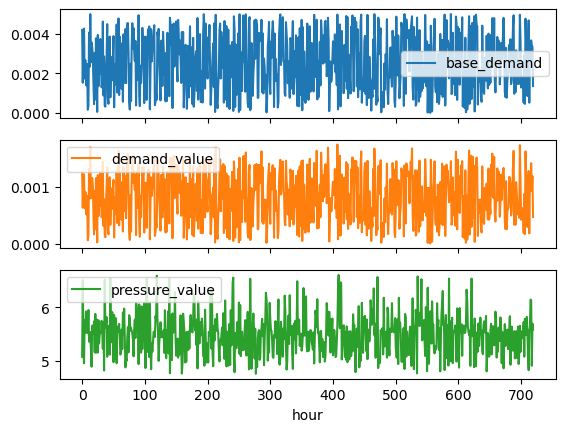

In [210]:
data = load_data()
data.xs(880001, level='ID', axis=1).plot(subplots=True, sharex=True)
data.head()

array([<Axes: xlabel='hour'>, <Axes: xlabel='hour'>,
       <Axes: xlabel='hour'>], dtype=object)

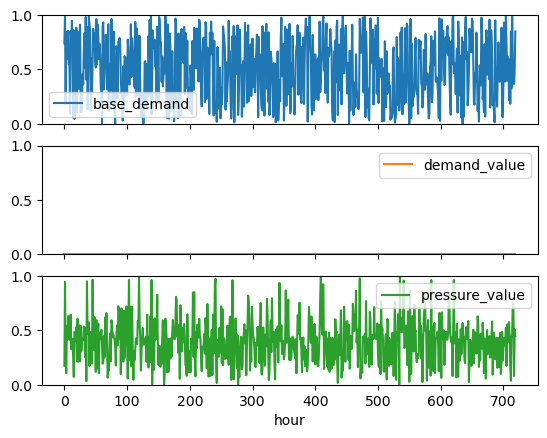

In [211]:
scaled_data, scaler = scale_data(data)
scaled_data = pd.DataFrame(scaled_data, index=data.index, columns=data.columns)
scaled_data.xs(880004, level='ID', axis=1).plot(subplots=True, ylim=(0, 1), sharex=True)

In [212]:
# Split the data in a features dataset and a target dataset
X, y = scaled_data.drop(columns=[TARGET], level=0), scaled_data[TARGET]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training on tensors of shape {X_train.shape} and {y_train.shape}")

Training on tensors of shape (576, 26) and (576, 13)


In [213]:
y_train.iloc[0]

ID
880000    0.626999
880001    0.247903
880002    0.141601
880003    0.000000
880004    0.000000
880005    0.038730
880006    0.288524
880007    0.000000
880008    0.000086
880009    0.000000
880010    0.000000
880011    0.629657
880012    0.489082
Name: 395, dtype: float64

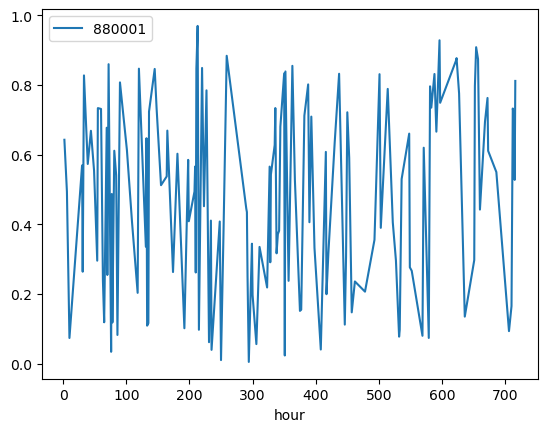

In [214]:
y_test.sort_index().reset_index().plot(x='hour', y=880001, kind='line')
plt.show()

In [215]:
def create_neural_network(X, y):
    # Take all the different elements in the network
    elements = np.unique(X.columns.get_level_values(1))
    # Take all the different features of each element in the network
    features = np.unique(X.columns.get_level_values(0))
    print(f"Creating Neural Network with {len(features) * len(elements)} features")

    # Create the Neural Network
    NN = Sequential()
    NN.add(Input(shape=(len(features) * len(elements),)))

    # NN.add(Dense(len(elements) * len(elements), activation='relu'))
    NN.add(Dense(100, activation='relu'))
    NN.add(Dense(100, activation='relu'))
    # Add the output layer
    NN.add(Dense(len(elements), activation='sigmoid'))
    return NN

In [216]:
NN = create_neural_network(X_train, y_train)
# Compile the Neural Network
NN.compile(optimizer='adam', loss='mean_squared_error')

Creating Neural Network with 26 features


In [217]:
# Train the Neural Network
NN.fit(X_train, y_train, batch_size=100, epochs=10)

Epoch 1/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.1486
Epoch 2/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.1156
Epoch 3/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step - loss: 0.0822
Epoch 4/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0529
Epoch 5/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0341
Epoch 6/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0270
Epoch 7/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0239
Epoch 8/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0221
Epoch 9/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0197
Epoch 10/10
6/6 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0184


In [218]:
# Test the Neural Network
y_pred = NN.predict(X_test)
y_pred = pd.DataFrame(y_pred, index=y_test.index, columns=y_test.columns)

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step


## Plot Predictions on the first 10 Nodes

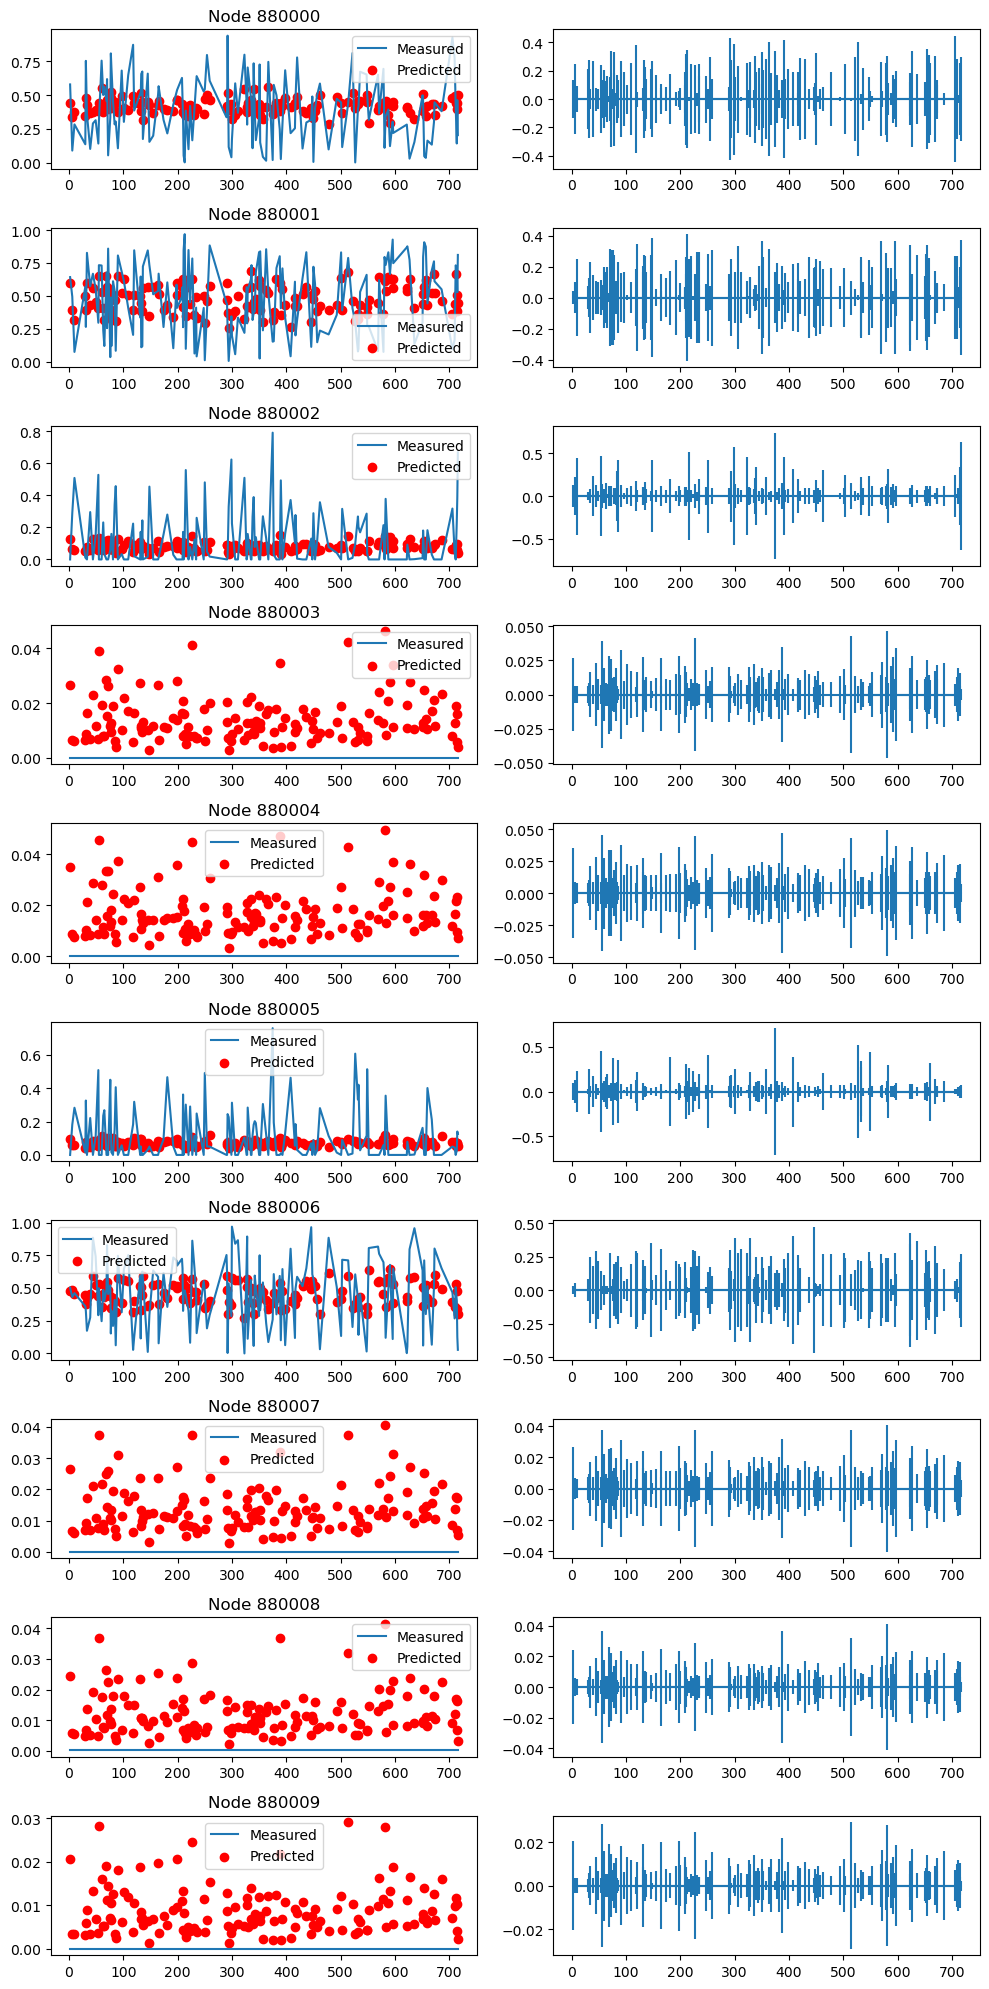

In [219]:
fig, axs = plt.subplots(10, 2, figsize=(10, 20), tight_layout=True)
for n_node, ax in enumerate(axs.T[0]):
    error_ax = axs.T[1][n_node]
    
    ys_test = y_test.sort_index().iloc[:, n_node]
    ys_pred = y_pred.sort_index().iloc[:, n_node]
    xs = y_test.sort_index().index
    
    ax.set_title(f"Node {y_pred.columns[n_node]}")
    ax.plot(xs, ys_test, label='Measured')
    ax.scatter(xs, ys_pred, label='Predicted', c='red')
    
    error = y_test.iloc[:, n_node] - y_pred.iloc[:, n_node]
    error_ax.errorbar(y_test.index, [0 for _ in y_test.iloc[:, n_node]], yerr=abs(error), label='Error')
    ax.legend()
plt.show()

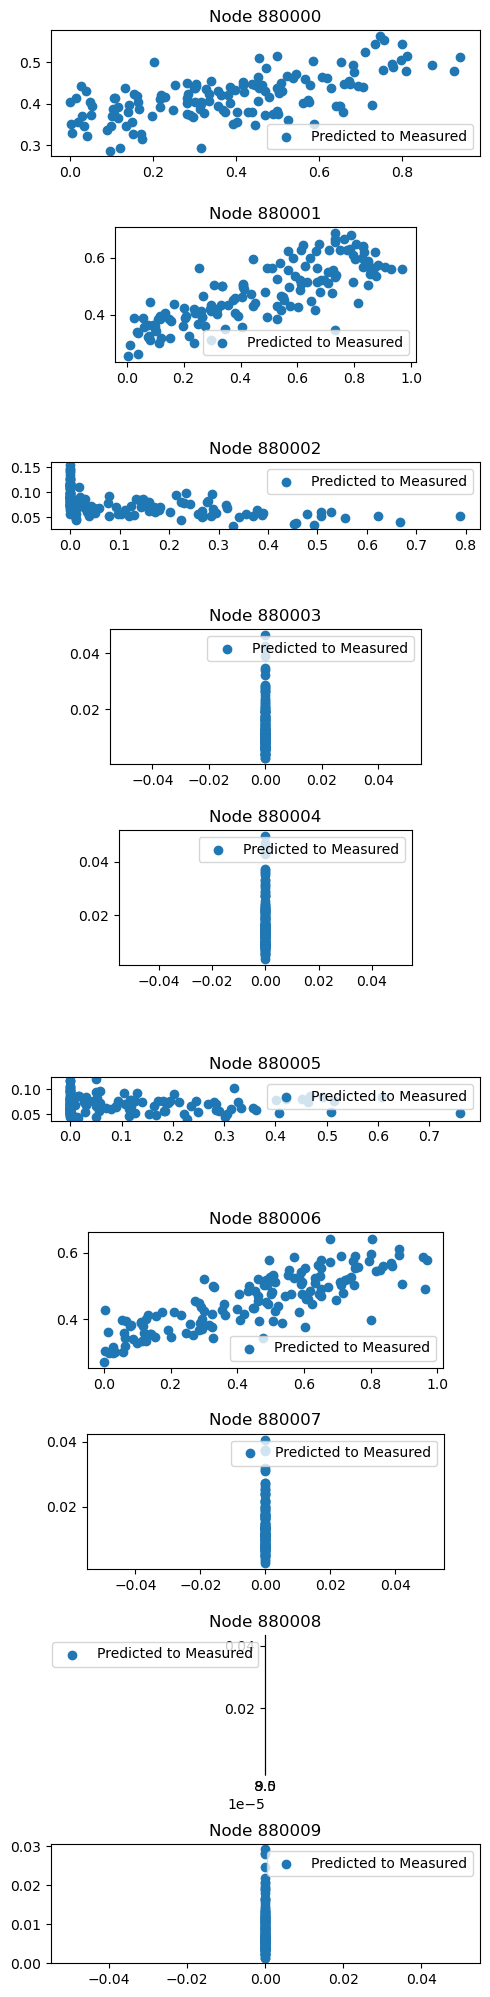

In [220]:
fig, axs = plt.subplots(10, figsize=(5, 20), tight_layout=True)
for n_node, ax in enumerate(axs):
    ys_pred = y_pred.iloc[:, n_node]
    ys_test = y_test.iloc[:, n_node]
    ax.set_title(f"Node {y_pred.columns[n_node]}")
    ax.scatter(ys_test, ys_pred, label='Predicted to Measured')
    ax.set_aspect('equal')
    ax.legend()
plt.show()

In [ ]:
x